In [9]:
import numpy as np
import pandas as pd
import torch
import transformers
import sklearn
import joblib
import matplotlib
import IPython
import scipy

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)
print("matplotlib:", matplotlib.__version__)
print("IPython:", IPython.__version__)
print("scipy:", scipy.__version__)

numpy: 1.25.2
pandas: 2.2.3
torch: 2.8.0+cu126
transformers: 4.55.2
scikit-learn: 1.7.1
joblib: 1.5.1
matplotlib: 3.6.3
IPython: 8.30.0
scipy: 1.9.3


In [3]:
import os
import math
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig, AutoModel
from sklearn.preprocessing import MinMaxScaler
import joblib

import matplotlib.pyplot as plt
from IPython import display
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import CubicSpline

## Parameter

In [228]:
class Config:
    # I, V, t column names in your exce
    INPUT_COLS = ["Current(A)", "Voltage(V)", "Time(s)"]
    TARGET_COLS = ["Voltage(V)", "SoC(%)"]

    OCV_FILE_PATH = '/content/drive/MyDrive/Masterarbeit/RCModel/OCV/OCVN10.xlsx'
    TRAIN_FILE_PATH = '/content/drive/MyDrive/Masterarbeit/RCModel/-10/N10_A1-007_US06.xlsx'
    Model_SAVE_DIR = "/content/drive/MyDrive/Masterarbeit/PIT_Models/"

    SEQ_LEN = 6000
    TRAIN_SPLIT = 0.8

    # head dims
    INPUT_DIM = 3
    HEAD_DIM = 5

    EPOCHS = 5000
    BATCH_SIZE = 100
    LR = 1e-4
    WEIGHT_DECAY = 0.0

    # battery constants
    ETA = 1.08 # coulombic efficiency
    Q_Ah = 1.1 # rated capacity [Ah]

    # loss weights (paper: α=0.2 for voltage; β=1.0 for SOC dynamics)
    ALPHA = 0.2
    BETA = 1.0

cfg = Config()

In [229]:
scaler_path = os.path.join(cfg.Model_SAVE_DIR, '-10IT_US06_scaler.joblib')

In [230]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## OCV - SoC

In [231]:
def ocv_lookup_from_excel(ocv_path: str, device: torch.device):


    # 1. 使用pandas加载和清洗数据
    df = pd.read_excel(ocv_path)
    soc_col, v_col = 'SoC(%)', 'Voltage(V)'
    df = df.dropna(subset=[soc_col, v_col])
    # 确保数据点在[0,1]之间且按SOC排序
    df = df[(df[soc_col] >= 0.0) & (df[soc_col] <= 1.0)]
    df = df.sort_values(by=soc_col).drop_duplicates(subset=[soc_col])

    soc_np = df[soc_col].to_numpy(np.float64)
    ocv_np = df[v_col].to_numpy(np.float64)

    # 2. 使用scipy计算三次样条的系数
    # 这是我们在模型训练外唯一一次使用scipy
    cs = CubicSpline(soc_np, ocv_np, bc_type='natural') # 使用自然边界条件

    # 3. 提取样条曲线的参数（节点和系数）并转换为PyTorch张量
    # 节点 (knots)
    knots = torch.tensor(cs.x, dtype=torch.float32, device=device)
    # 节点处的OCV值
    knots_ocv = torch.tensor(ocv_np, dtype=torch.float32, device=device)
    # 分段多项式系数，cs.c的形状为(4, n-1)，对应(x-x_i)的3,2,1,0次幂系数
    coeffs = torch.tensor(cs.c, dtype=torch.float32, device=device)

    # 4. 返回一个完全可微的、使用PyTorch实现的样条插值函数
    def ocv_fn(soc_q: torch.Tensor) -> torch.Tensor:
        """
        根据输入的SOC张量，使用预计算的样条系数计算OCV。
        - 内部插值: 使用分段三次多项式。
        - 外部插值: 使用边界点的一阶导数进行线性外插。
        此函数完全可微。
        """
        # 创建一个用于存放结果的空张量
        y = torch.zeros_like(soc_q)

        # 识别三个区域：低于下边界、在边界内、高于上边界
        is_below = soc_q < knots[0]
        is_above = soc_q > knots[-1]
        is_within = ~(is_below | is_above)

        # --- a) 处理在边界内的值 ---
        if torch.any(is_within):
            soc_within = soc_q[is_within]

            # 使用searchsorted高效地找到每个soc值所在的区间索引
            indices = torch.searchsorted(knots, soc_within, right=True) - 1
            # 钳制索引以防万一（数值精度问题）
            indices = torch.clamp(indices, 0, len(knots) - 2)

            # 提取对应区间的参数
            x_i = knots[indices]
            a_i, b_i, c_i, d_i = coeffs[0, indices], coeffs[1, indices], coeffs[2, indices], coeffs[3, indices]

            # 计算分段三次多项式: a(x-xi)^3 + b(x-xi)^2 + c(x-xi) + d
            dx = soc_within - x_i
            y_within = a_i * dx**3 + b_i * dx**2 + c_i * dx + d_i
            y[is_within] = y_within

        # --- b) 处理低于下边界的值 (线性外插) ---
        if torch.any(is_below):
            # 样条在第一个节点处的导数(斜率)是c_0
            slope_low = coeffs[2, 0]
            # 使用点斜式 y = y1 + m(x - x1)
            y_low = knots_ocv[0] + slope_low * (soc_q[is_below] - knots[0])
            y[is_below] = y_low

        # --- c) 处理高于上边界的值 (线性外插) ---
        if torch.any(is_above):
            # 计算样条在最后一个节点处的导数(斜率)
            last_idx = len(knots) - 2
            x_i, x_ip1 = knots[last_idx], knots[last_idx + 1]
            a_i, b_i, c_i = coeffs[0, last_idx], coeffs[1, last_idx], coeffs[2, last_idx]
            dx_end = x_ip1 - x_i
            slope_high = 3 * a_i * dx_end**2 + 2 * b_i * dx_end + c_i

            # 使用点斜式 y = y1 + m(x - x1)
            y_high = knots_ocv[-1] + slope_high * (soc_q[is_above] - knots[-1])
            y[is_above] = y_high

        return y

    print(f"OCV-SoC curve loaded and wrapped as a differentiable spline function.")
    return ocv_fn

In [232]:
ocv_file_path = cfg.OCV_FILE_PATH
ocv_func = ocv_lookup_from_excel(ocv_file_path, device)
test_soc = torch.tensor([0.5, 0.8]).to(device)
corresponding_ocv = ocv_func(test_soc)
print(corresponding_ocv)

OCV-SoC curve loaded and wrapped as a differentiable spline function.
tensor([3.2212, 3.2573], device='cuda:0')


## Load Data

In [233]:
class BatteryDataset(Dataset):

    def __init__(self, df: pd.DataFrame, seq_len: int, scaler: MinMaxScaler, config: "Config"):

        self.seq_len = seq_len
        self.scaler = scaler

        # 1. 清洗数据
        df_clean = df.dropna(subset=[*config.INPUT_COLS, *config.TARGET_COLS])
        df_clean = df_clean[(df_clean[config.TARGET_COLS[1]] > 0.0) & (df_clean[config.TARGET_COLS[1]] < 1.0)]

        # 2. 提取并转换数据为Tensor
        inputs_raw = df_clean.loc[:, config.INPUT_COLS].to_numpy(np.float32)
        model_inputs = df_clean.loc[:, config.INPUT_COLS].to_numpy(np.float32)
        targets = df_clean.loc[:, config.TARGET_COLS].to_numpy(np.float32)
        inputs_scaled = self.scaler.transform(model_inputs)

        self.scaled_data = torch.from_numpy(inputs_scaled)
        self.raw_data = torch.from_numpy(inputs_raw)
        self.target_data = torch.from_numpy(targets)

        n_samples = len(df_clean)

        if n_samples >= self.seq_len:
            # 模式1：长度足够，进行非重叠分块，并舍弃末尾
            self.num_sequences = n_samples // self.seq_len
            self._mode = 'chunking'  # 设置模式为“分块”
        else:
            # 模式2：长度不足，将整体作为一个序列
            self.num_sequences = 1 if n_samples > 0 else 0 # 如果清洗后为空则序列数为0
            self._mode = 'full'      # 设置模式为“整体”


    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx: int):

        if self._mode == 'chunking':
            # 在“分块”模式下，返回第idx个不重叠的块
            start_idx = idx * self.seq_len
            end_idx = start_idx + self.seq_len

            scaled_inputs = self.scaled_data[start_idx:end_idx]
            raw_inputs = self.raw_data[start_idx:end_idx]
            targets = self.target_data[start_idx:end_idx]

        else: # self._mode == 'full'
            # 在“整体”模式下，直接返回全部数据
            # 此时 idx 必然为 0
            scaled_inputs = self.scaled_data
            raw_inputs = self.raw_data
            targets = self.target_data

        return scaled_inputs, raw_inputs, targets

## Model Structure

In [234]:
class PITransformer(nn.Module):
    def __init__(self, backbone: nn.Module, in_dim: int, out_dim: int):
        super().__init__()
        self.d_model = backbone.config.hidden_size
        self.in_proj = nn.Linear(in_dim, self.d_model)
        self.backbone = backbone

        # 单一的输出头，输出5个物理量
        self.head = nn.Linear(self.d_model, out_dim)



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_proj(x)
        out = self.backbone(inputs_embeds=x).last_hidden_state

        output = self.head(out)


        R0 = torch.nn.functional.softplus(output[:, :, 0])
        R1 = torch.nn.functional.softplus(output[:, :, 1])
        C1 = torch.nn.functional.softplus(output[:, :, 2])
        SOC = 1.5 * torch.sigmoid(output[:, :, 3]) - 0.25
        Uoc = output[:, :, 4]


        y = torch.stack([R0, R1, C1, SOC, Uoc], dim=-1)  # (batch, seq_len, 5)


        return y

In [235]:
class Transformer(nn.Module):

    def __init__(self, backbone: nn.Module, in_dim: int):
        super().__init__()
        self.d_model = backbone.config.hidden_size
        self.in_proj = nn.Linear(in_dim, self.d_model)
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(self.d_model, 1),
            #nn.Sigmoid()
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_proj(x)
        out = self.backbone(inputs_embeds=x).last_hidden_state
        soc = self.head(out)
        return soc.squeeze(-1) # Shape: (B, L)

## Physics Loss

In [236]:
class PhysLoss(nn.Module):
    def __init__(self, ocv_fn, eta: float, Q_Ah: float, alpha: float, beta: float):
        super().__init__()
        self.ocv_fn = ocv_fn
        self.eta = eta
        self.Q_As = Q_Ah * 3600.0
        self.alpha = alpha
        self.beta = beta
        self.mse = nn.MSELoss()

    def forward(self, pred: torch.Tensor, raw_inputs: torch.Tensor, targets: torch.Tensor):
        """pred: (B,L,5) -> [R0,R1,C1,SOC,UOC]
        raw_inputs: (B,L,3) -> [I,V,t] (UNSCALED)
        targets: (B,L,2) -> [V_true, SOC_true]
        """
        I = raw_inputs[..., 0]
        V_true = targets[..., 0]
        t = raw_inputs[..., 2]

        R0 = pred[..., 0]
        R1 = pred[..., 1]
        C1 = pred[..., 2]
        SOC = pred[..., 3]
        UOC = pred[..., 4]

        # dt per step; replicate last to keep shape (B,L)
        dt = t[:, 1:] - t[:, :-1]
        dt = torch.cat([dt, dt[:, -1:]], dim=1)

        # RC branch current I1 (per paper Eq.5)
        tau = (R1 * C1).clamp_min(1e-6)

        I1_list = []

        # 2. 将 I1 的初始值（即 I 的第一个点）作为列表的第一个元素
        initial_I1 = I[:, 0]
        I1_list.append(initial_I1)

        # 3. 在循环中，计算下一步的值，并将其 append 到列表中
        tau = (R1 * C1).clamp_min(1e-6)
        for k in range(I.shape[1] - 1):
            a = torch.exp(-dt[:, k] / tau[:, k])
            # I1_list[-1] 获取上一步的 I1 值
            I1_next = a * I1_list[-1] + (1.0 - a) * I[:, k]
            I1_list.append(I1_next)

        # 4. 循环结束后，将列表中的所有张量堆叠成一个最终的 I1 张量
        #    这个操作是“非原地的”，会创建一个全新的张量
        I1 = torch.stack(I1_list, dim=1)


        # Predicted terminal voltage UL
        U0 = R0 * I
        V_pred = UOC - R1 * I1 - U0

        # 1) terminal voltage fit loss
        loss_ul = self.mse(V_pred, V_true)

        # 2) OCV-SOC consistency: UOC ≈ h(SOC)
        UOC_ref = self.ocv_fn(SOC) #SOC.detach()
        loss_uoc = self.mse(UOC, UOC_ref)




        rhs_instant = -(self.eta / self.Q_As) * I[:, :-1] * dt[:, :-1]
        rhs_instant = torch.clamp(rhs_instant, min=-0.01, max=0.01)  # Prevent extremes

        # 2. 计算理论上的 “累积” 变化量 (对rhs进行累加)
        #    torch.cumsum 会计算累积和
        #    我们在开头补零，使其长度与SOC序列匹配
        rhs_cumulative = torch.cat([torch.zeros_like(rhs_instant[:, 0:1]), torch.cumsum(rhs_instant, dim=1)], dim=1)

        # 3. 计算模型预测的 “累积” 变化量
        #    用每个点的SoC减去序列的第一个点SoC
        soc_initial = SOC[:, 0:1] # 保持维度以便广播
        soc_pred_cumulative_change = SOC - soc_initial

        # 4. 计算累积形式的PDE损失
        #    强制模型的累积变化与理论的累积变化相匹配
        loss_soc = self.mse(soc_pred_cumulative_change, rhs_cumulative)

        total = self.alpha * (loss_ul + loss_uoc) + self.beta * loss_soc
        return total, loss_ul, loss_uoc, loss_soc


## Training

## main

In [237]:
# --- 步骤一: 加载数据并进行划分 ---
print("--- Loading and Splitting Data ---")
full_df = pd.read_excel(cfg.TRAIN_FILE_PATH)

current_col = cfg.INPUT_COLS[0]  # "Current(A)"
full_df[current_col] = full_df[current_col] * -1 #Discharge is POSITIVE!!!

full_df = full_df[(full_df[cfg.TARGET_COLS[1]] > 0.0) & (full_df[cfg.TARGET_COLS[1]] < 1.0)]
split_idx = int(len(full_df) * cfg.TRAIN_SPLIT)
train_df = full_df.iloc[:split_idx]
val_df = full_df.iloc[split_idx:]
print(f"Data split: {len(train_df)} for training, {len(val_df)} for validation.")

--- Loading and Splitting Data ---
Data split: 4074 for training, 1019 for validation.


In [238]:
scaler = joblib.load(scaler_path)

sequence_len = len(train_df)

train_dataset = BatteryDataset(train_df, sequence_len, scaler, cfg)
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)

val_dataset = BatteryDataset(val_df, sequence_len, scaler, cfg)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)

ocv_fn = ocv_lookup_from_excel(cfg.OCV_FILE_PATH, device,)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


OCV-SoC curve loaded and wrapped as a differentiable spline function.


In [239]:
transformer_config = AutoConfig.from_pretrained(
    "bert-base-uncased", # Use a standard config as a template
    max_position_embeddings=9000,

    # Increase model complexity for better performance on long sequences
    hidden_size=128,              # Model dimension
    num_hidden_layers=8,          # Number of encoder layers
    num_attention_heads=8,        # Number of attention heads
    intermediate_size=512         # Dimension of the FFN layer
)

# Initialize a model with this new configuration (random weights)
transformer_backbone = AutoModel.from_config(config=transformer_config)
pi_transformer_backbone = AutoModel.from_config(config=transformer_config)


## Test and Visualization

In [240]:
PI_model_path = os.path.join(cfg.Model_SAVE_DIR, '-10ITBEST_US06_model.pth')
Data_model_path = os.path.join(cfg.Model_SAVE_DIR, 'bestTransformer_N10_US06_model.pth')


In [241]:
PI_model = PITransformer(
    backbone=pi_transformer_backbone,
    in_dim=cfg.INPUT_DIM,
    out_dim=cfg.HEAD_DIM
).to(device)

Data_model = Transformer(
    backbone=transformer_backbone,
    in_dim=cfg.INPUT_DIM,
    #out_dim=cfg.HEAD_DIM
).to(device)

PI_model.load_state_dict(torch.load(PI_model_path, map_location=device))
Data_model.load_state_dict(torch.load(Data_model_path, map_location=device))

<All keys matched successfully>

In [242]:
loss_fn = PhysLoss(ocv_fn, eta=cfg.ETA, Q_Ah=cfg.Q_Ah, alpha=cfg.ALPHA, beta=cfg.BETA)

PI_SOC_RMSE: 0.0203 | PI_SOC_MAE: 0.0182 | DATA_SOC_RMSE: 0.2858 | DATA_SOC_MAE: 0.2842


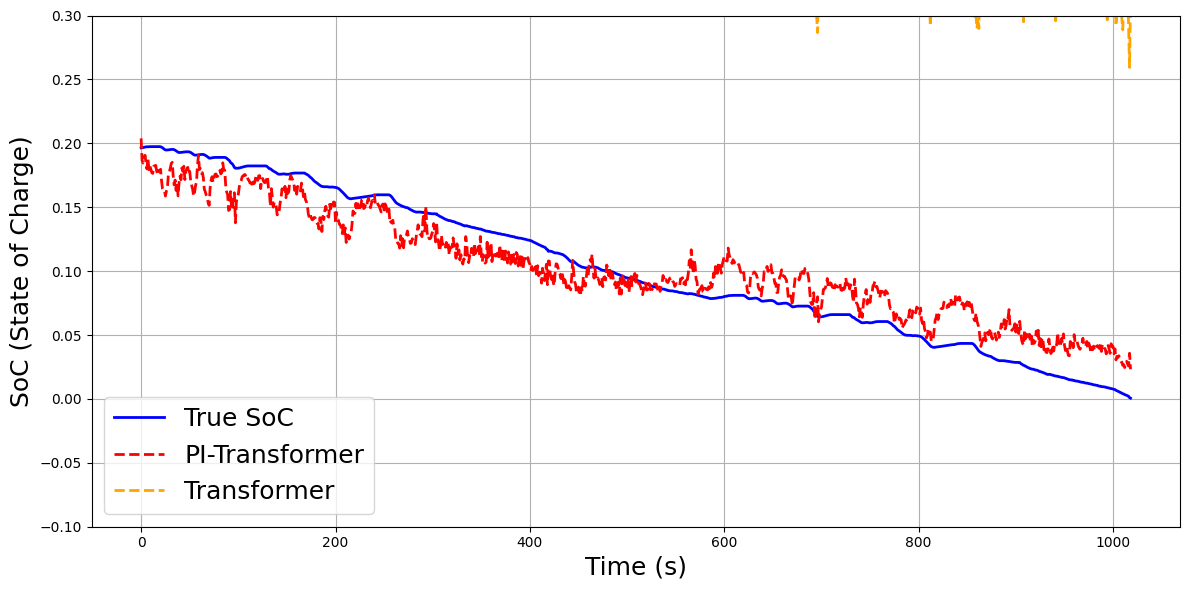

In [243]:
mse = nn.MSELoss()
PI_model.eval()
Data_model.eval()
pi_soc_preds, data_soc_preds, soc_trues = [], [], []
pi_all_soc_preds, data_all_soc_preds, all_soc_trues, pi_all_preds, data_all_preds, all_trues = None, None, None, None, None, None # 先进行初始化


with torch.no_grad():

      for xs_scaled, xs_raw, ys in val_loader:
          xs_scaled, xs_raw, ys = xs_scaled.to(device), xs_raw.to(device), ys.to(device)
          pi_pred = PI_model(xs_scaled)
          data_pred = Data_model(xs_scaled)

          pi_soc_preds.append(pi_pred[..., 3].detach().cpu())
          data_soc_preds.append(data_pred.detach().cpu())
          soc_trues.append(ys[..., 1].cpu())

      pi_all_preds = torch.cat(pi_soc_preds).view(-1)
      data_all_preds = torch.cat(data_soc_preds).view(-1)
      all_trues = torch.cat(soc_trues).view(-1)

      pi_all_soc_preds = pi_all_preds.numpy()
      data_all_soc_preds = data_all_preds.numpy()
      all_soc_trues = all_trues.numpy()

      pi_soc_rmse = np.sqrt(np.mean((pi_all_soc_preds - all_soc_trues) ** 2))
      pi_soc_mae = np.mean(np.abs(pi_all_soc_preds - all_soc_trues))

      data_soc_rmse = np.sqrt(np.mean((data_all_soc_preds - all_soc_trues) ** 2))
      data_soc_mae = np.mean(np.abs(data_all_soc_preds - all_soc_trues))




print(f"PI_SOC_RMSE: {pi_soc_rmse:.4f} | PI_SOC_MAE: {pi_soc_mae:.4f} | DATA_SOC_RMSE: {data_soc_rmse:.4f} | DATA_SOC_MAE: {data_soc_mae:.4f}")




fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(all_soc_trues, label='True SoC', color='blue', linewidth=2)
ax.plot(pi_all_soc_preds, label='PI-Transformer', color='red', linestyle='--', linewidth=2)
ax.plot(data_all_soc_preds, label='Transformer', color='orange', linestyle='--', linewidth=2)

# 3. 设置图表的标题和标签
#ax.set_title('Test Set: True vs. Predicted SoC', fontsize=18)
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('SoC (State of Charge)', fontsize=18)
ax.grid(True)
ax.legend(fontsize=18)
ax.set_ylim(-0.1, 0.3)

plt.tight_layout()

save_path = "/content/drive/MyDrive/Masterarbeit/PIT_Plots/20_FUDS"
#plt.savefig(save_path)


plt.show()
